In [1]:
# Clear memory
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import ipywidgets
ipywidgets.Widget.close_all()

import SimpleITK
import datetime
import gc # Garbage collected
import numpy as np
import sys, os
import time
import tifffile
import matplotlib.pyplot as plt
import scipy
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askopenfilenames, askdirectory
import torch
import skimage
from skimage import measure
from skimage.morphology import skeletonize
import pickle
import networkx as nx
import sknw # https://github.com/Image-Py/sknw

import multiprocessing

this_path = os.getcwd()
print(this_path)


import h5py
# import File
from scripts import *
import wrapper_ASTRA

/global/cfs/cdirs/als/users/eboigne/cfoster/code/als6/tomoTools_als832/tomoTools


In [3]:
path_save = '/global/homes/e/eboigne/cfs_als/2022_wood/'

# case = 'run21_oak_lowHeat'
# case = 'run23_walnut_lowHeat'
# case = 'run24_birch_lowHeat'
case = 'run26_birch_highHeat'

voxel_size = 3.24*2 # [microns]

list_cases_folder_name = sorted([e for e in os.listdir(path_save+case) if not 'probe' in e and not '.tif' in e and not '.pickle' in e])
run = case[3:5]+'_Sample'
list_cases_h5 = sorted([e for e in os.listdir(path_save) if '.h5' in e and run in e])

print(list_cases_folder_name)

['01', '02', '03', '04', '05', '06', '07a', '07b', '08a', '08b', '09a', '09b', '10a', '10b', '11a', '11b', '12a', '12b', '13a', '13b', '14a', '14b', '15a', '15b', '16a', '16b', '17a', '17b', '18a', '18b', '19a', '19b', '20a', '20b', '21a', '21b', '22a', '22b', '23a', '23b', '24a', '24b', '25a', '25b', '26a', '26b', '27-post', '28-post', '29-post', '30-post', '31-post', '32-post']


In [4]:
ind_slice = 250

slices = []
for ind_case, this_case in enumerate(list_cases_folder_name[:]):
    slices.append(File(path_save+case+'/'+this_case+'/b_movingRegisteredToStatic/').read(ind_slice))
    print(ind_case, this_case)

slices = np.array(slices)
print(slices.shape)
File(path_save+case+'/probe_slice_'+str(ind_slice).zfill(4)).saveTiffStack(slices)

0 01
1 02
2 03
3 04
4 05
5 06
6 07a
7 07b
8 08a
9 08b
10 09a
11 09b
12 10a
13 10b
14 11a
15 11b
16 12a
17 12b
18 13a
19 13b
20 14a
21 14b
22 15a
23 15b
24 16a
25 16b
26 17a
27 17b
28 18a
29 18b
30 19a
31 19b
32 20a
33 20b
34 21a
35 21b
36 22a
37 22b
38 23a
39 23b
40 24a
41 24b
42 25a
43 25b
44 26a
45 26b
46 27-post
47 28-post
48 29-post
49 30-post
50 31-post
51 32-post
(52, 1280, 1280)


In [5]:
c = []
for this_case in enumerate(list_cases_h5):
    c.append(this_case[1][35:37])

t = []

list_scans = []

for this_case in enumerate(c):
    if str(this_case[1]) in list_cases_folder_name or '-post' in [e for e in list_cases_folder_name if this_case[1] in e][0]:
        cc = list_cases_h5[this_case[0]][9:15]
        h = cc[0:2]
        m = cc[2:4]
        s = cc[4:]
        ts = float(int(h)*3600+int(m)*60+int(s))
        t.append(ts) #c
        print(len(t), this_case, 'c', ts)
    else:
        cc = list_cases_h5[this_case[0]][9:15]
        h = cc[0:2]
        m = cc[2:4]
        s = cc[4:]
        ts0 = float(int(h)*3600+int(m)*60+int(s))
        t.append(ts0) #a
        ts1 = 26.26 + ts0
        t.append(ts1) #b
        print(len(t), this_case, 'a/b', ts0 ,ts1)

scan_times = np.array(t) - t[0]


for ind_scan,scan_time in enumerate(scan_times):
    this_scan = Data()
    # print(ind_scan)
    this_scan.scan_time = scan_time
    this_scan.folder_name = list_cases_folder_name[ind_scan]
    this_scan.full_path = path_save+case+'/'+this_scan.folder_name
    this_scan.ind = ind_scan
    list_scans.append(this_scan) #list_scans is just array of this_scans Data() classes 

assert(len(list_cases_folder_name) ==len(scan_times)), 'Wrong sizes'

1 (0, '01') c 72742.0
2 (1, '02') c 72933.0
3 (2, '03') c 73113.0
4 (3, '04') c 73298.0
5 (4, '05') c 73481.0
6 (5, '06') c 73672.0
8 (6, '07') a/b 73672.0 73698.26
10 (7, '08') a/b 74348.0 74374.26
12 (8, '09') a/b 74537.0 74563.26
14 (9, '10') a/b 74727.0 74753.26
16 (10, '11') a/b 74915.0 74941.26
18 (11, '12') a/b 75100.0 75126.26
20 (12, '13') a/b 75399.0 75425.26
22 (13, '14') a/b 75594.0 75620.26
24 (14, '15') a/b 75780.0 75806.26
26 (15, '16') a/b 75964.0 75990.26
28 (16, '17') a/b 76172.0 76198.26
30 (17, '18') a/b 76362.0 76388.26
32 (18, '19') a/b 76555.0 76581.26
34 (19, '20') a/b 76733.0 76759.26
36 (20, '21') a/b 76945.0 76971.26
38 (21, '22') a/b 77178.0 77204.26
40 (22, '23') a/b 77404.0 77430.26
42 (23, '24') a/b 77608.0 77634.26
44 (24, '25') a/b 77812.0 77838.26
46 (25, '26') a/b 78006.0 78032.26
47 (26, '27') c 78196.0
48 (27, '28') c 78383.0
49 (28, '29') c 78566.0
50 (29, '30') c 78746.0
51 (30, '31') c 78921.0
52 (31, '32') c 79100.0


In [7]:
print(list_cases_folder_name)

['01', '02', '03', '04', '05', '06', '07a', '07b', '08a', '08b', '09a', '09b', '10a', '10b', '11a', '11b', '12a', '12b', '13a', '13b', '14a', '14b', '15a', '15b', '16a', '16b', '17a', '17b', '18a', '18b', '19a', '19b', '20a', '20b', '21a', '21b', '22a', '22b', '23a', '23b', '24a', '24b', '25a', '25b', '26a', '26b', '27-post', '28-post', '29-post', '30-post', '31-post', '32-post']


In [4]:
def compute_mask_solid(this_scan, data, force_redo = False):

    if force_redo or not 'b_movingRegisteredToStatic_maskSolid' in os.listdir(this_scan.full_path):

        threshold = 0.05 # Linear attenuation threshold [/cm], gas to wood
        threshold_needle = 4.0 # Linear attenuation threshold [/cm]
        mask_growth_needle = 10 # Grow the mask obtained using threshold_needle with this amount of pixels
        mask_enclosing_circle = tifffile.imread(path_save+case+'/maskEnclosingCircle.tif') > 0
        bin_factor_dilatation = 1 # Binning before smoothing, as an option to speed things up for large kernels
        filter_half_width = 3 # After binning (equal to sigma for gaussian filter)

        kernel = custom_3d_gaussian_filter(filter_half_width)

        if bin_factor_dilatation > 1:
            data_smoothed = fast_pytorch_bin_3d(data,bin_factor_dilatation, chunk_size = 71)
        else:
            data_smoothed = data

        print('\t3D smoothing for thresholding of mask_solid and mask_needle:')
        data_smoothed = apply_3d_image_processing_on_subvolumes(data_smoothed, fast_pytorch_convolution, kernel_array = kernel, chunk_size_max = (500, 500, 500), overlap = 3*filter_half_width)

        if bin_factor_dilatation > 1:
            data_smoothed = skimage.transform.rescale(data_smoothed, bin_factor_dilatation, multichannel=False)

        mask_needle = data_smoothed > threshold_needle
        mask_needle = apply_3d_image_processing_on_subvolumes(mask_needle, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = mask_growth_needle, radius = mask_growth_needle)

        mask_solid = data_smoothed > threshold
        mask_solid[mask_needle] = False

        for ind, slice in enumerate(mask_solid):
            slice[~mask_enclosing_circle] = False
            mask_solid[ind] = slice

        print('\tSaving mask_solid and mask_needle:')
        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskNeedle').saveTiffStack(mask_needle, type = 'bool')
        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolid').saveTiffStack(mask_solid, type = 'bool')
    else:
        print('\tRe-loading mask solid and mask needle')
        mask_solid = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolid').readAll()
        mask_needle = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskNeedle').readAll()

    return(mask_solid.astype('bool'), mask_needle.astype('bool'))

def compute_height(properties):
    for prop in properties:
        bbox = prop.bbox
        prop.height = bbox[3]-bbox[0] # Along z, in pixels
    return(properties)

def compute_equivalent_cylinder_diameters(properties):
    for prop in properties:
        equivalent_cylinder_cross_section = prop.area / prop.height
        prop.equivalent_cylinder_diameter = np.sqrt(4*equivalent_cylinder_cross_section/np.pi) * voxel_size
    return(properties)

def get_path_length(graph, path):
    this_sum=0
    for i in range(len(path)-1):
        this_sum += graph.get_edge_data(path[i], path[i+1])['weight']
    return(this_sum)

def longest_simple_path(graph, source, target):
    longest_path = None
    longest_path_length = 0
    for path in nx.all_simple_paths(graph, source=source, target=target):
        path_length = get_path_length(graph,path)
        if path_length > longest_path_length:
            longest_path_length = path_length
            longest_path = path
    return longest_path, longest_path_length

def find_longest_subgraph_from_ends(graph, bbox):

    ind_end_nodes = [x for x in graph.nodes if graph.degree(x) == 1]
    ind_end_bottom = [x for x in ind_end_nodes if graph.nodes[x]['o'][0] - bbox[0] <=  bbox[3] - graph.nodes[x]['o'][0]]
    ind_end_top = [x for x in ind_end_nodes if not x in ind_end_bottom]

    longest_path_subgraph = None
    longest_path_length = 0
    longest_path = []
    for ind_bot in ind_end_bottom:
        for ind_top in ind_end_top:
            this_longest_path, this_longest_path_length = longest_simple_path(graph, source=ind_bot, target=ind_top)
            this_longest_path_subgraph = graph.subgraph(this_longest_path)

            if this_longest_path_length > longest_path_length:
                longest_path_length = this_longest_path_length
                longest_path = this_longest_path
                longest_path_subgraph = this_longest_path_subgraph

    return(longest_path_subgraph, longest_path, longest_path_length)

def compute_tortuosity(skeleton_properties):

    for ind_pore in range(len(skeleton_properties)):
        bbox = skeleton_properties[ind_pore].bbox
        graph = sknw.build_sknw(skeleton_properties[ind_pore].image, multi=False, iso=False, ring=False, full=True)
        longest_path_subgraph, longest_path, longest_path_length = find_longest_subgraph_from_ends(graph, bbox)

        if longest_path_length == 0:
            longest_path_length = np.nan

        skeleton_properties[ind_pore].length_skeleton = longest_path_length
        skeleton_properties[ind_pore].longest_path = longest_path
        # skeleton_properties[ind_pore].longest_path_subgraph = longest_path_subgraph
        skeleton_properties[ind_pore].tortuosity = longest_path_length / skeleton_properties[ind_pore].height

        # print(ind_pore, longest_path_length, skeleton_properties[ind_pore].tortuosity)
    return(skeleton_properties)

def compute_skeleton(this_scan, mask_pores, force_redo = False):

    if force_redo or not 'b_movingRegisteredToStatic_maskPores_skeleton' in os.listdir(this_scan.full_path):
        skeleton = skeletonize(mask_pores)
        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskPores_skeleton').saveTiffStack(skeleton, type = 'bool')
    else:
        print('\tRe-loading skeleton')
        skeleton = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskPores_skeleton').readAll()
    return(skeleton)

def find_top_bottom_slices_ind(this_scan, mask_solid, ind_all_top, ind_all_bottom):

    this_scan.ind_all_margin = 100
    this_scan.ind_margin = 30
    this_scan.relative_porosity_threshold = 0.15

    mask_solid_slice_sum = np.sum(np.sum(mask_solid, axis = 2), axis = 1)
    mean_area_ind_all = np.mean(mask_solid_slice_sum[ind_all_top+this_scan.ind_all_margin:ind_all_bottom-this_scan.ind_all_margin])

    this_scan.relative_porosity = np.abs(mean_area_ind_all-mask_solid_slice_sum)/mean_area_ind_all

    this_scan.ind_top = np.min(np.where(this_scan.relative_porosity<this_scan.relative_porosity_threshold)) + this_scan.ind_margin
    this_scan.ind_bottom = np.max(np.where(this_scan.relative_porosity<this_scan.relative_porosity_threshold)) - this_scan.ind_margin

    this_scan.height_ROI = this_scan.ind_bottom-this_scan.ind_top + 1

    print('\t\tDetected ROI:\tind_top: '+str(this_scan.ind_top)+', ind_bottom: '+str(this_scan.ind_bottom)+', height: '+str(this_scan.height_ROI))
    if (this_scan.height_ROI < 200):
        print('\t\t\t\t/!\ WARNING: small height of ROI detected: check the cropping of mask solid')

    return(this_scan)

def mask_crop_ROI(mask, ind_top, ind_bottom):
    mask[:ind_top] = False
    mask[ind_bottom:] = False
    return(mask)

def close_mask_solid(this_scan, mask_solid, mask_needle, force_redo = False):

    if force_redo or not 'b_movingRegisteredToStatic_maskSolidClosed' in os.listdir(this_scan.full_path):

        # Option #1: Morphological closing to close the pores
        # chunk_size = (500, 500, 500)
        # filter_half_width = 12
        # structure = custom_3d_kernel_sphere(filter_half_width)
        # mask_solid_dilated = apply_3d_image_processing_on_subvolumes(mask_solid, fast_pytorch_mask_dilation, chunk_size_max = chunk_size, overlap = filter_half_width, radius = filter_half_width)
        # mask_solid_closed = ~apply_3d_image_processing_on_subvolumes(~mask_solid_dilated, fast_pytorch_mask_dilation, chunk_size_max = chunk_size, overlap = filter_half_width, radius = filter_half_width)

        # Option #2: Fill holes algorithm run slice by slice
        n_threads = 16
        mask_solid_closed = np.zeros_like(mask_solid)
        with multiprocessing.Pool(n_threads) as p:
            mask_solid_closed = np.array(p.map(scipy.ndimage.morphology.binary_fill_holes, mask_solid))

        # 1 core version of option #2
        # for ind, slice in enumerate(mask_solid):
        #     mask_solid_closed[ind] = scipy.ndimage.morphology.binary_fill_holes(slice)
        #     print(ind)

        mask_solid_closed[mask_needle] = False
        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolidClosed').saveTiffStack(mask_solid_closed, type = 'bool')
    else:
        print('\tRe-loading mask solid closed')
        mask_solid_closed = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolidClosed').readAll()

    return(mask_solid_closed.astype('bool'))

def rotate_data(data, rot_coronal_Fiji, rot_sagittal_Fiji, rot_z_Fiji = 0.0):
    pad = 1
    transform_rotation = sitk.Euler3DTransform()
    center_xyz = (data.shape[0] / 2.0+pad, data.shape[1] / 2.0+pad, data.shape[2] / 2.0+pad) # TODO: Is this correct? Not consistent with below
    center_angle = 0.0
    offsets_xyz = (0.0, 0.0, 0.0)

    transform_rotation.SetFixedParameters((center_xyz[0], center_xyz[1], center_xyz[2], center_angle))
    eulerAngle_xyz_deg = (-rot_sagittal_Fiji, rot_coronal_Fiji, 0.0)
    transform_rotation.SetParameters((eulerAngle_xyz_deg[0]/180.0*np.pi, eulerAngle_xyz_deg[1]/180.0*np.pi, eulerAngle_xyz_deg[2]/180.0*np.pi, offsets_xyz[0], offsets_xyz[1], offsets_xyz[2]))

    data_bigger = np.zeros([data.shape[0]+pad*2, data.shape[1]+pad*2, data.shape[2]+pad*2])
    data_bigger[pad:-pad, pad:-pad, pad:-pad] = data
    data_out = applyTransformToVolume(data_bigger, data_bigger, transform_rotation)

    # Then only axial rotation. Can't do all axis at once to match Fiji
    if rot_z_Fiji != 0:
        center_xyz = (data_out.shape[2] / 2.0, data_out.shape[1] / 2.0, data_out.shape[0] / 2.0)
        transform_rotation.SetFixedParameters((center_xyz[0], center_xyz[1], center_xyz[2], center_angle))
        eulerAngle_xyz_deg = (0.0, 0.0, -rot_z_Fiji)
        offsets_xyz2 = (0.0, -50.0, 0.0)
        transform_rotation.SetParameters((eulerAngle_xyz_deg[0]/180.0*np.pi, eulerAngle_xyz_deg[1]/180.0*np.pi, eulerAngle_xyz_deg[2]/180.0*np.pi, offsets_xyz2[0], offsets_xyz2[1], offsets_xyz2[2]))
        data_out2 = applyTransformToVolume(data_out, data_out, transform_rotation)
    else:
        data_out2 = data_out

    return(data_out2[pad:-pad, pad:-pad, pad:-pad])

def analyze_pores_2d(this_scan, mask_pores):
    tic = time.time()

    this_scan.slice_angles_to_growth = []
    this_scan.slice_ellipse_major_diameters = []
    this_scan.slice_ellipse_minor_diameters = []
    this_scan.slice_ellipse_eccentricity = []
    this_scan.slice_areas = []
    this_scan.slice_eq_diameters = []
    this_scan.slice_perimeters = []

    for ind, slice in enumerate(mask_pores):
        slice_lab = measure.label(slice)
        slice_properties = np.array(measure.regionprops(slice_lab))

         # Angle w.r.t vertical (growth axis), with positive being CCW, in degrees, from -90 to 90
        angles = 180 / np.pi * np.array([p.orientation for p in slice_properties]) # From -90 to 90
        # angles[angles<0] = 180+angles[angles<0]
        this_scan.slice_angles_to_growth.append(angles)

        this_scan.slice_ellipse_major_diameters.append(np.array([p.axis_major_length for p in slice_properties]))
        this_scan.slice_ellipse_minor_diameters.append(np.array([p.axis_minor_length for p in slice_properties]))
        this_scan.slice_ellipse_eccentricity.append(np.array([p.eccentricity for p in slice_properties]))
        this_scan.slice_eq_diameters.append(np.array([p.equivalent_diameter_area for p in slice_properties]))
        this_scan.slice_perimeters.append(np.array([p.perimeter for p in slice_properties]))
        this_scan.slice_areas.append(np.array([p.area for p in slice_properties]))

        if ind % 100 == 0:
            print('.', end='')

    return(this_scan)

def mean_attenuation_volume(this_scan, mask_to_use, data):
    mu_s = np.nanmean(data[mask_to_use])
    V_s = np.nansum(mask_to_use.flatten())
    V_s_m = np.nansum(mask_to_use.flatten())*(voxel_size*10**-6)**3 #[m3]
    return(mu_s,V_s, V_s_m)

In [9]:
# Rotation
rot_coronal_Fiji = np.nan # [Deg]
rot_sagittal_Fiji = np.nan # [Deg]
rot_z_Fiji = np.nan # [Deg] This angle: such that tree growth is vertical from bottom to top in Fiji, after sagittal / coronal rotation

# Top and bottom indices along z that contain sample for all scans (after rotation /!\)
ind_all_top = np.nan
ind_all_bottom = np.nan

In [10]:
# Rotation
rot_coronal_Fiji = np.nan # [Deg]
rot_sagittal_Fiji = np.nan # [Deg]
rot_z_Fiji = np.nan # [Deg] This angle: such that tree growth is vertical from bottom to top in Fiji, after sagittal / coronal rotation

# Top and bottom indices along z that contain sample for all scans (after rotation /!\)
ind_all_top = np.nan
ind_all_bottom = np.nan

In [11]:
# Rotation
rot_coronal_Fiji = -1.0 # [Deg]
rot_sagittal_Fiji = -5.0 # [Deg]
rot_z_Fiji = -91.5 # [Deg] This angle: such that tree growth is vertical from bottom to top in Fiji, after sagittal / coronal rotation

# Top and bottom indices along z that contain sample for all scans (after rotation /!\)
ind_all_top = 130
ind_all_bottom = 465


In [12]:
# Rotation
rot_coronal_Fiji = -0.2 # [Deg]
rot_sagittal_Fiji = 0.5 # [Deg]
rot_z_Fiji = 40.0 # [Deg] This angle: such that tree growth is vertical from bottom to top in Fiji, after sagittal / coronal rotation

# Top and bottom indices along z that contain sample for all scans (after rotation /!\)
ind_all_top = 170
ind_all_bottom = 480


In [13]:
ind_scan = 0
this_scan = list_scans[ind_scan]
print('Running scan #'+str(ind_scan+1)+' - '+this_scan.folder_name)

Running scan #1 - 01


In [14]:
# Re-load scan data
with open(path_save+case+'/post_pro_data.pickle', 'rb') as handle:
    list_scans = pickle.load(handle)

nb_scans = len(list_scans)
force_redo = False

for ind_scan,this_scan in enumerate(list_scans):
    tic_scan = time.time()

    print('Running scan #'+str(ind_scan+1)+'/'+str(nb_scans)+' - '+this_scan.folder_name)

    # Loading data
    tic = time.time()
    data = File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic/').readAll()
    print('\tLoading data took: '+str(time.time()-tic))

    # Rotating data
    tic = time.time()
    data = rotate_data(data, rot_coronal_Fiji, rot_sagittal_Fiji, rot_z_Fiji)
    print('\tRotating data took: '+str(time.time()-tic))
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedZ/').saveTiff(data[data.shape[0]//2-100,:,:], ind=0)
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedZ/').saveTiff(data[data.shape[0]//2,:,:], ind=1)
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedZ/').saveTiff(data[data.shape[0]//2+100,:,:], ind=2)
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedXY/').saveTiff(data[:,data.shape[1]//2,:], ind=0)
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedXY/').saveTiff(data[:,:,data.shape[2]//2], ind=1)

    # Computing mask solid and mask needle
    mask_solid, mask_needle = compute_mask_solid(this_scan, data, force_redo = force_redo)

    # Crop mask solid
    this_scan = find_top_bottom_slices_ind(this_scan, mask_solid, ind_all_top, ind_all_bottom)
    mask_solid = mask_crop_ROI(mask_solid, this_scan.ind_top, this_scan.ind_bottom)

    # Close mask_solid and compute porosity
    print('\tClosing mask solid')
    mask_solid_closed = close_mask_solid(this_scan, mask_solid, mask_needle, force_redo = force_redo)
    this_scan.porosity = 1 - np.sum(mask_solid.flatten()) / np.sum(mask_solid_closed.flatten())

    # Compute mean solid attenuation and solid volume
    this_scan.mu_solid_open, this_scan.volume_solid_open, this_scan.volume_solid_open_m3 = mean_attenuation_volume(this_scan, mask_solid, data)
    this_scan.mu_solid_closed, this_scan.volume_solid_closed, this_scan.volume_solid_closed_m3 = mean_attenuation_volume(this_scan, mask_solid_closed, data)

    # # Analyze pore structure (3D)
    # mask_pores = mask_solid_closed * (~mask_solid)
    # tic = time.time()
    # lab = measure.label(mask_pores)
    # properties = np.array(measure.regionprops(lab))
    # print('\tParticle identification and analysis took: '+str(time.time()-tic))

    # # Cleaning up pores (3D)
    # properties = compute_height(properties)
    # areas = np.array([prop.area for prop in properties])
    # height = np.array([prop.height for prop in properties])
    # this_scan.ind_properties_cleaned = np.where((areas>500) * (areas < 300000) * (height > 100))[0]
    # properties_cleaned = properties[this_scan.ind_properties_cleaned]

    # # Compute equivalent cylinder diameters (3D)
    # properties_cleaned = compute_equivalent_cylinder_diameters(properties_cleaned)
    # this_scan.nb_pores = len(properties_cleaned)
    # # this_scan.pore_properties = properties_cleaned # Don't save this, otherwise pickle too heavy (image data stored)

    # # Analyze pore structure (2D, slice by slice)
    # print('\tStarting 2D pore analysis ', end ='')
    # tic = time.time()
    # this_scan = analyze_pores_2d(this_scan, mask_pores)
    # print(' Done, it took: '+str(time.time()-tic))

    # # Build and analyze skeleton for tortuosity
    # tic = time.time()
    # skeleton = compute_skeleton(this_scan, mask_pores, force_redo = force_redo)
    # skeleton_lab = measure.label(skeleton)
    # skeleton_properties = measure.regionprops(skeleton_lab)
    # print('\tSkeletonize and analysis took: '+str(time.time()-tic))

    # # Extract which pores to keep from skeleton
    # skeleton_properties = compute_height(skeleton_properties)
    # skeleton_areas = np.array([prop.area for prop in skeleton_properties])
    # skeleton_height = np.array([prop.height for prop in skeleton_properties])
    # this_scan.skeleton_ind_properties_cleaned = np.where((skeleton_areas>50) * (skeleton_areas < 1000) * (skeleton_height > 100))[0]

    # # Compute tortuosity for each pore
    # skeleton_properties_cleaned = compute_tortuosity(np.array(skeleton_properties)[this_scan.skeleton_ind_properties_cleaned])

    # # Save relevant pore & skeleton properties
    # this_scan.areas = [prop.area for prop in properties_cleaned]
    # this_scan.equivalent_cylinder_diameters = [prop.equivalent_cylinder_diameter for prop in properties_cleaned]
    # this_scan.heights = [prop.height for prop in properties_cleaned]
    # this_scan.skeleton_pore_path_length = [prop.length_skeleton for prop in skeleton_properties_cleaned]
    # this_scan.tortuosity = [prop.tortuosity for prop in skeleton_properties_cleaned if not np.isnan(prop.tortuosity) and prop.tortuosity > 1]

    # Update save of scan data
    print('\tUpdating save pickle')
    with open(path_save+case+'/post_pro_data.pickle', 'wb') as handle:
        pickle.dump(list_scans, handle)

    print('\tThis scan took: '+str(time.time()-tic_scan))
print('Done')


Running scan #1/52 - 01
	Loading data took: 49.28241300582886
	Rotating data took: 9.986969232559204
	Re-loading mask solid and mask needle
		Detected ROI:	ind_top: 127, ind_bottom: 587, height: 461
	Closing mask solid
	Re-loading mask solid closed
	Updating save pickle
	This scan took: 92.66976189613342
Running scan #2/52 - 02
	Loading data took: 56.50691771507263
	Rotating data took: 13.032991886138916
	Re-loading mask solid and mask needle
		Detected ROI:	ind_top: 127, ind_bottom: 587, height: 461
	Closing mask solid
	Re-loading mask solid closed
	Updating save pickle
	This scan took: 124.30123829841614
Running scan #3/52 - 03
	Loading data took: 59.098586559295654
	Rotating data took: 16.397929430007935
	Re-loading mask solid and mask needle
		Detected ROI:	ind_top: 127, ind_bottom: 587, height: 461
	Closing mask solid
	Re-loading mask solid closed
	Updating save pickle
	This scan took: 105.45171284675598
Running scan #4/52 - 04
	Loading data took: 53.003820180892944
	Rotating data

IndexError: boolean index did not match indexed array along dimension 0; dimension is 674 but corresponding boolean dimension is 698

In [52]:
with open(path_save+case+'/post_pro_data.pickle', 'rb') as handle:
    list_scans = pickle.load(handle)

this_scan = list_scans[6]
this_scan.__dict__.keys()
# this_scan. #should see keys by just tabbing over 

dict_keys(['scan_time', 'folder_name', 'full_path', 'porosity', 'ind_properties_cleaned', 'nb_pores', 'skeleton_ind_properties_cleaned', 'areas', 'equivalent_cylinder_diameters', 'heights', 'skeleton_pore_path_length', 'tortuosity', 'ind', 'ind_all_margin', 'ind_margin', 'relative_porosity_threshold', 'relative_porosity', 'ind_top', 'ind_bottom', 'height_ROI', 'slice_angles_to_growth', 'slice_ellipse_major_diameters', 'slice_ellipse_minor_diameters', 'slice_ellipse_eccentricity', 'slice_areas', 'slice_eq_diameters', 'slice_perimeters'])

In [11]:
#collin scratch
this_scan = list_scans[6]
force_redo = False
# data = File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic/').readAll()
mask_solid, mask_needle = compute_mask_solid(this_scan, data, force_redo = force_redo)

ind_all_top = np.nan
ind_all_bottom = np.nan
# Crop mask solid
this_scan = find_top_bottom_slices_ind(this_scan, mask_solid, ind_all_top, ind_all_bottom)
mask_solid = mask_crop_ROI(mask_solid, this_scan.ind_top, this_scan.ind_bottom)


def mean_attenuation_volume(this_scan, mask_to_use, data):
    mu_s = np.nanmean(data[mask_to_use])
    V_s = np.nansum(mask_to_use.flatten())
    V_s_m = np.nansum(mask_to_use.flatten())*(voxel_size*10**-6)**3 #[m3]
    return(mu_s,V_s, V_s_m)

def Xc(x):
    return(x - mu_sb) / (mu_sc - mu_sb)
Xc_solid = np.apply_along_axis(Xc, -1, gsSolid)
def rho(x):
    return(x*rho_sc + (1-x)*rho_sb)
rho_sx = np.apply_along_axis(rho, -1, chi_sx)

# this_scan.mu_solid_open, this_scan.volume_solid_open, this_scan.volume_solid_open_m3 = mean_attenuation_volume(this_scan, mask_solid, data)

print(this_scan.mu_solid_open)


	Re-loading mask solid and mask needle


TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
# pull pickle

path_save = '/global/homes/e/eboigne/cfs_als/2022_wood/'

case = ['run21_oak_lowHeat', 'run23_walnut_lowHeat', 'run24_birch_lowHeat', 'run26_birch_highHeat']
mass_in = [86,60,77,82] #mg
mass_out = [21,15,12,14] #mg

n = 2
case = case[n]
mass_in = mass_in[n] #mg
mass_out = mass_out[n] #mg

with open(path_save+case+'/post_pro_data.pickle', 'rb') as handle:
    list_scans = pickle.load(handle)

# load single data set for testing
this_scan = list_scans[15]
data = File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic/').readAll()

In [15]:
# solve Xc and rho

def density(mass_in, mass_out, volume):
    rho_in = mass_in / volume
    rho_out = mass_out / volume
    return(rho_in, rho_out)

for ind_scan,this_scan in enumerate(list_scans):
    this_scan = list_scans[ind_scan]
    this_scan.mass_in_kg = mass_in * 10e-6 
    this_scan.mass_out_kg = mass_out * 10e-6

    this_scan.rho_in_solid_not_cropped_open_kgm3, this_scan.rho_out_solid_not_cropped_open_kgm3 = density(this_scan.mass_in_kg, this_scan.mass_out_kg, this_scan.volume_solid_not_cropped_open_m3)
    this_scan.rho_in_solid_not_cropped_closed_kgm3, this_scan.rho_out_solid_not_cropped_closed_kgm3 = density(this_scan.mass_in_kg, this_scan.mass_out_kg, this_scan.volume_solid_not_cropped_closed_m3)
    this_scan.rho_in_solid_open_kgm3, this_scan.rho_out_solid_open_kgm3 = density(this_scan.mass_in_kg, this_scan.mass_out_kg, this_scan.volume_solid_open_m3)
    this_scan.rho_in_solid_closed_kgm3, this_scan.rho_out_solid_closed_kgm3 = density(this_scan.mass_in_kg, this_scan.mass_out_kg, this_scan.volume_solid_closed_m3)


# begin taking biomass values at 4th index, use `solid_closed` for mu and rho, solve for zeta

## pull mean value from first and last sets for calibration
# mu_b = []
# mu_c = []
# rho_b = []
# rho_c = []
# for ind_scan in range(3):
#     mu_b.append(list_scans[ind_scan].mu_solid_not_cropped_open)
#     mu_c.append(list_scans[-ind_scan-1].mu_solid_not_cropped_open) 
#     rho_b.append(list_scans[ind_scan].rho_solid_open_kgm3) 
#     rho_c.append(list_scans[-ind_scan-1].rho_solid_open_kgm3) 
# mu_sb = np.nanmean(mu_b)
# mu_sc = np.nanmean(mu_c)
# rho_sb = np.nanmean(rho_b)
# rho_sc = np.nanmean(rho_c)

## pull single values for calibration
mu_solid_b = list_scans[3].mu_solid_closed
mu_solid_c = list_scans[-2].mu_solid_closed 
rho_solid_b= list_scans[3].rho_in_solid_closed_kgm3
rho_solid_c= list_scans[-2].rho_out_solid_closed_kgm3 

## pull maps
Xc_solid=[]
rho_solid=[]
def Xc(x):
    return((x - mu_solid_b) / (mu_solid_c - mu_solid_b))
def rho(x):
    return(x*rho_solid_c + (1-x)*rho_solid_b)

slice_maps = np.linspace(0, data.shape[1], 10, dtype=int)
for slice_num in enumerate(slice_maps):
    Xc_solid.append(np.apply_along_axis(Xc, -1, data[:,slice_num[1]-1,:]))
    rho_solid.append(np.apply_along_axis(rho, -1, Xc_solid[slice_num[0]]))


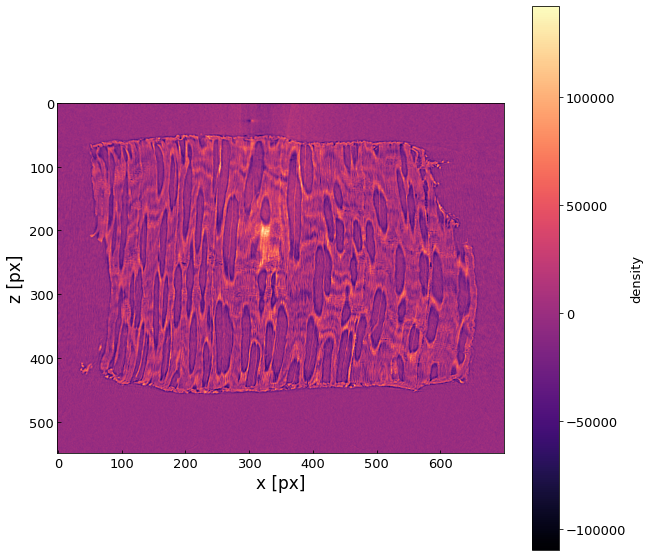

In [16]:
# plot single map

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
p1 = ax.imshow(rho_solid[4][50:600,300:1000], cmap='magma')
cbar = plt.colorbar(p1)
cbar.ax.tick_params(labelsize=13)
cbar.set_label(label='density', size=13)
ax.tick_params(axis="x", direction="in", labelsize=13)
ax.tick_params(axis="y", direction="in", labelsize=13)
plt.xlabel('x [px]', fontsize=17)
plt.ylabel('z [px]', fontsize=17)
plt.show()


In [14]:
print(np.mean(Xc_solid[4][50:600,300:1000]))
print(np.max(Xc_solid[4][50:600,300:1000]))
print(np.min(Xc_solid[4][50:600,300:1000]))

1.6875992
35.45344
-39.826492


In [33]:
this_scan = list_scans[2]
this_scan.__dict__.keys()

dict_keys(['scan_time', 'folder_name', 'full_path', 'ind', 'ind_all_margin', 'ind_margin', 'relative_porosity_threshold', 'relative_porosity', 'ind_top', 'ind_bottom', 'height_ROI', 'porosity', 'ind_properties_cleaned', 'nb_pores', 'slice_angles_to_growth', 'slice_ellipse_major_diameters', 'slice_ellipse_minor_diameters', 'slice_ellipse_eccentricity', 'slice_areas', 'slice_eq_diameters', 'slice_perimeters', 'skeleton_ind_properties_cleaned', 'areas', 'equivalent_cylinder_diameters', 'heights', 'skeleton_pore_path_length', 'tortuosity', 'mu_solid_open', 'volume_solid_open', 'volume_solid_open_m3', 'mu_solid_closed', 'volume_solid_closed', 'volume_solid_closed_m3', 'mu_solid_not_cropped_open', 'volume_solid_not_cropped_open', 'volume_solid_not_cropped_open_m3', 'mu_solid_not_cropped_closed', 'volume_solid_not_cropped_closed', 'volume_solid_closed_not_cropped_m3', 'porosity_not_cropped', 'mass_in_kg', 'mass_out_kg'])

In [ ]:
print(len(list_scans))

ind_scan = 34

print(list_scans[ind_scan].ind)
print(list_scans[ind_scan].folder_name)
print(list_scans[ind_scan].porosity)
print(list_scans[ind_scan].nb_pores)


In [43]:
ind_slice_X = 600-1 # Reslice from Top in Fiji
ind_slice_Y = 620-1 # Reslice from Left in Fiji
nb_scans = len(list_scans)

for ind_scan,this_scan in enumerate(list_scans[34:]):

    print('Loading scan #'+str(ind_scan+1)+'/'+str(nb_scans)+' - '+this_scan.folder_name)

    # Loading data
    tic = time.time()
    data = File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic/').readAll()
    print('\tLoading data took: '+str(time.time()-tic))

    File(path_save+case+'/probe_sliceX_'+str(ind_slice_X).zfill(4)).saveTiff(data[:,ind_slice_X,:], ind = this_scan.ind)
    File(path_save+case+'/probe_sliceY_'+str(ind_slice_Y).zfill(4)).saveTiff(data[:,:,ind_slice_Y], ind = this_scan.ind)

Loading scan #1/52 - 21a
	Loading data took: 29.47336220741272
Loading scan #2/52 - 21b
	Loading data took: 28.624576807022095
Loading scan #3/52 - 22a
	Loading data took: 29.96585750579834
Loading scan #4/52 - 22b
	Loading data took: 28.03941583633423
Loading scan #5/52 - 23a
	Loading data took: 26.810391426086426
Loading scan #6/52 - 23b
	Loading data took: 28.192319869995117
Loading scan #7/52 - 24a
	Loading data took: 28.19716763496399
Loading scan #8/52 - 24b
	Loading data took: 27.833656787872314
Loading scan #9/52 - 25a
	Loading data took: 27.228797912597656
Loading scan #10/52 - 25b
	Loading data took: 27.412358283996582
Loading scan #11/52 - 26a
	Loading data took: 27.326425313949585
Loading scan #12/52 - 26b
	Loading data took: 26.930753707885742
Loading scan #13/52 - 27-post
	Loading data took: 26.810258865356445
Loading scan #14/52 - 28-post
	Loading data took: 28.123441219329834
Loading scan #15/52 - 29-post
	Loading data took: 27.962918519973755
Loading scan #16/52 - 30-p

In [ ]:
print(time.time())